<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/New_S12_TinyImageNet_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-04-18 11:50:14.833231


In [0]:
%config IPCompleter.greedy=True
%reload_ext autoreload

In [0]:
import os.path
from os import path
import requests
from tqdm import tqdm
from zipfile import ZipFile

def download_file(folder_path, url):

        # get the file name
        file_name = url.split("/")[-1]
        folder_path = folder_path + "/" + file_name

        if path.exists(folder_path):
            print('File: {} already downloaded.'.format(file_name))
            return folder_path

        # read 1024 bytes every time
        buffer_size = 1024
        # download the body of response by chunk, not immediately
        response = requests.get(url, stream=True)

        # get the total file size
        file_size = int(response.headers.get("Content-Length", 0))

        # progress bar, changing the unit to bytes instead of iteration (default by tqdm)
        progress = tqdm(response.iter_content(buffer_size), f"Downloading {folder_path}", total=file_size, unit="B",
                        unit_scale=True, unit_divisor=1024)
        with open(folder_path, "wb") as f:
            for data in progress:
                # write data read to the file
                f.write(data)
                # update the progress bar manually
                progress.update(len(data))
        print('folder_path',folder_path)
        return folder_path

In [0]:
def extract_zip_file(file_path, extract_path):

        file_name = file_path.split("/")[-1]
        print('file_name 1:',file_name)
        file_name = file_name.split(".")[0]
        print('file_name 2:',file_name)
        output_folder = extract_path + '/' + file_name

        if path.exists(output_folder):
            print('File: {} already extracted.'.format(file_name))
            return output_folder

        print('Extracting file from {} to {}'.format(file_path, extract_path))
        with ZipFile(file_path, 'r') as zipObj:
            # Extract all the contents of zip file in different directory
            zipObj.extractall(extract_path)

        print('File extraction completed.',ouput_folder)
        return output_folder

In [0]:
def download_dataset(folder_path):
        url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
        folder_path = download_file(folder_path, url=url)

        return extract_zip_file(file_path=folder_path, extract_path='data')

In [0]:
path = download_dataset(folder_path="data")
print('path',path)

In [0]:
#drive.flush_and_unmount()

In [0]:
!pip install scipy==1.1.0

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/tiny-imagenet-200.zip"
!ls

In [0]:
!pwd

In [0]:
# Copying the code from github to drive
%cd gdrive/My Drive/project_folder
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/S12_TinyImageNet_ResNet
! ls

In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
#from models import Alb_data_transforms,Model,Dataloaders,Train_Losses,Test_losses
import pkgutil
import importlib
import os
%matplotlib inline

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)  

In [0]:
tiny_image_net_mean = [0.48043722, 0.44820285, 0.39760238]
tiny_image_net_std = [0.27698976, 0.26908714, 0.2821603]

In [25]:
import time
import numpy as np
path = '/content/tiny-imagenet-200/'
dict1 = get_id_dictionary(path=path)
values, classes = get_class_to_id_dict(id_dict=dict1, path=path)

train_data, train_label, test_data, test_label = get_train_test_labels_data(dict1, path)

100%|██████████| 200/200 [00:00<00:00, 2379.39it/s]
10000it [00:00, 658270.79it/s]

Starting data loading
Finished data loading, in 0.10996842384338379 seconds


In [0]:
compose_train, compose_test = getalbumentationstraintesttransforms(tiny_image_net_mean, tiny_image_net_std)

In [0]:
train_dataset = get_tiny_imagenet_train_dataset(train_image_data=train_data, train_image_labels=train_label,
                                                train_transforms=compose_train)

In [0]:
test_dataset =  get_tiny_imagenet_test_dataset(test_image_labels=test_label, test_image_data=test_data,
                                               test_transforms=compose_test)

In [63]:
batch_size = 512
data_loader = Dataloader(traindataset=train_dataset, testdataset=test_dataset, batch_size=batch_size)

CUDA Available? True
512


In [0]:
train_loader = data_loader.gettraindataloader()

In [0]:
test_loader = data_loader.gettestdataloader()

In [67]:
data_iterator = iter(train_loader)
PlotData.showImagesfromdataset(data_iterator, classes=classes)

TypeError: ignored

In [59]:
train_data.shape

(77000,)

In [0]:
    ## Wnids.txt has 200 classes with IDs like n02124075, n04067472 etc. 'get_id_dictionary' creates a dictionary of these class IDs in
    ## format as {n02124075:0, n03838899:20,...}
    def get_id_dictionary(path):
        id_dict = {}
        for i, line in enumerate(open(path + '/wnids.txt', 'r')):
            id_dict[line.replace('\n', '')] = i
        return id_dict
  ## words.txt has class names corresponding to 82115 class IDs. Using 'id_dict' created from 'get_id_dictionary' we will create 2 things:
  ## a) 'values' -> A dictionary having elements like 0: ('n02124075', 'Egyptian cat\n'), 3: ('n04099969', 'rocking chair, rocker\n') corresponding to IDs present in id_dict
  ## b) 'classes'-> A list of all 82115 classes. Out of these 82115, we are using only 200 in tinyimagenet data which we capture in 'values' dictionary 

    def get_class_to_id_dict(id_dict, path):
        # id_dict = self.get_id_dictionary(path)
        all_classes = {}
        class_labels = []
        result = {}
        for i, line in enumerate(open(path + '/words.txt', 'r')):
            n_id, word = line.split('\t')[:2]
            all_classes[n_id] = word
            class_labels.append(word)          
        for key, value in id_dict.items():
            result[value] = (key, all_classes[key])
        return result, class_labels

    def get_train_test_labels_data(id_dict, path, test_split=0.3):
        print('Starting data loading')

        train_data, test_data = [], []
        train_labels, test_labels = [], []
        t = time.time()
        total_val_images = 10000
        images_for_class = 500
        train_image_count = images_for_class - (images_for_class * test_split)
        for key, value in tqdm(id_dict.items()):
            all_data, all_labels = [], []
            for i in range(images_for_class):
                all_data.append(path + '/train/{}/images/{}_{}.JPEG'.format(key, key, str(i)))
                all_labels.append(id_dict[key])

            for x in range(0, images_for_class):
                if x < train_image_count:
                    train_data.append(all_data[x])
                    train_labels.append(all_labels[x])
                else:
                    test_data.append(all_data[x])
                    test_labels.append(all_labels[x])

        test_image_count = total_val_images - (total_val_images * test_split)
        val_count = 0
        for line in tqdm(open(path + '/val/val_annotations.txt')):
            img_name, class_id = line.split('\t')[:2]
            if val_count < test_image_count:
                train_data.append(path + '/val/images/{}'.format(img_name))
                train_labels.append(id_dict[class_id])
            else:
                test_data.append(path + '/val/images/{}'.format(img_name))
                test_labels.append(id_dict[class_id])

            val_count += 1

        print('Finished data loading, in {} seconds'.format(time.time() - t))
        return np.array(train_data), train_labels, np.array(test_data), test_labels

    def get_classes(path):
        id_dict = get_id_dictionary(path=path)
        values, class_labels = get_class_to_id_dict(id_dict=id_dict, path=path)
        return class_labels, id_dict

In [0]:
    def get_tiny_image_net_test_train_loader(id_dict, path, batch_size):
        #train_data, train_label, test_data, test_label = self.get_train_test_labels_data(id_dict, path)

        #from src.utils import tiny_image_net_mean
        #from src.utils import tiny_image_net_std
        #compose_train, compose_test = getalbumentationstraintesttransforms(
        #    tiny_image_net_mean, tiny_image_net_std)

        #from src.dataset import Dataset
        #ds = Dataset()
        #train_dataset = get_tiny_imagenet_train_dataset(train_image_data=train_data, train_image_labels=train_label,
        #                                                   train_transforms=compose_train)
        #test_dataset =  get_tiny_imagenet_test_dataset(test_image_labels=test_label, test_image_data=test_data,
        #                                                 test_transforms=compose_test)

        #from src.dataset import Dataloader
        #data_loader = Dataloader(traindataset=train_dataset, testdataset=test_dataset, batch_size=batch_size)
        #train_loader = data_loader.gettraindataloader()
        #test_loader = data_loader.gettestdataloader()

        return test_loader, train_loader

In [0]:
    def getalbumentationstraintesttransforms(mean, std):
        preproc = AlbumentaionsTransforms()
        train_transforms = preproc.gettraintransforms(mean, std)
        test_transforms = preproc.gettesttransforms(mean, std)
        compose_train = CustomCompose(train_transforms)
        compose_test = CustomCompose(test_transforms)
        return compose_train, compose_test

In [0]:
import cv2
import albumentations 
from albumentations import Compose, Flip, pytorch, Normalize, OneOf, MotionBlur, MedianBlur, Blur, \
                           ShiftScaleRotate, OpticalDistortion, GridDistortion, HueSaturationValue, \
                           Cutout, GaussNoise, RandomCrop, PadIfNeeded, IAAAdditiveGaussianNoise  

class AlbumentaionsTransforms(object):

    def gettraintransforms(mean, std, p=1):
        # Train Phase transformations
        albumentations_transform = Compose([
            # RandomRotate90(),
            PadIfNeeded(72, 72, border_mode=cv2.BORDER_REFLECT, always_apply=True),
            RandomCrop(64, 64, True),
            Flip(),
            IAAAdditiveGaussianNoise(),
            #GaussNoise(p=0.8, mean=mean),
            OneOf([
                MotionBlur(p=0.4),
                MedianBlur(blur_limit=3, p=0.2),
                Blur(blur_limit=3, p=0.2),
            ], p=0.4),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.6),
            OneOf([
                OpticalDistortion(p=0.8),
                GridDistortion(p=0.4),
            ], p=0.6),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.6),
            #CoarseDropout(always_apply=True, max_holes=1, min_holes=1, max_height=16, max_width=16,
            #$              fill_value=(255 * .6), min_height=16, min_width=16),
            Normalize(mean=mean, std=std, always_apply=True),
            Cutout(num_holes=1,max_h_size=16,max_w_size=16),
            pytorch.ToTensorV2(always_apply=True),

        ], p=p)

        return albumentations_transform;

    def gettesttransforms(self, mean, std):
        # Test Phase transformations
        return Compose([
            Normalize(mean=mean, std=std, always_apply=True),
            pytorch.ToTensorV2(always_apply=True),
        ])        

In [0]:
class CustomCompose:
    def __init__(self,transforms):
        self.transforms = transforms

    def __call__(self, img):
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

In [0]:
def get_tiny_imagenet_train_dataset(train_transforms, train_image_data, train_image_labels):
    return TinyImagenetDataset(image_data=train_image_data, image_labels=train_image_labels,
                                   transform=compose_train)

def get_tiny_imagenet_test_dataset(test_transforms, test_image_data, test_image_labels):
    return TinyImagenetDataset(image_data=test_image_data, image_labels=test_image_labels,
                                   transform=compose_test)

In [0]:
import io
import os
# from imageio import imread
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch

class TinyImagenetDataset(Dataset):
    """Tiny Imagenet dataset."""

    def __init__(self, image_data, image_labels, transform=None):
        self.transform = transform
        self.image_data = image_data
        self.image_labels = image_labels

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_data[idx]))
        label = self.image_labels[idx]
        # label = label.astype('float').reshape(-1, 2)
        # sample = {'image': image, 'label': label}

        if self.is_grayscale_image(image):
            image = np.stack((image,) * 3, axis=-1)
            # image = np.squeeze(np.stack((image,) * 3, -1))

        if self.transform:
            image = self.transform(Image.fromarray(image))

        return image, label

    def is_grayscale_image(self, image):
        return (len(image.shape) == 2) or (len(image.shape) == 3 and image.shape[-1] == 1)

In [0]:
class Dataloader(object):

    def __init__(self, traindataset, testdataset, batch_size=64):
        self.traindataset = traindataset
        self.testdataset = testdataset

        # number of subprocesses to use for data loading
        self.num_workers = 0
        # how many samples per batch to load
        self.batch_size = 64
        # percentage of training set to use as validation
        # valid_size = 0.2

        seed = 1
        # For reproducibility
        torch.manual_seed(seed)

        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        if cuda:
            self.batch_size = batch_size
            self.num_workers = 4
            self.pin_memory = True
        else:
            self.shuffle = True
            self.batch_size = batch_size

        print(self.batch_size)

    def gettraindataloader(self):
        return torch.utils.data.DataLoader(dataset=self.traindataset, batch_size=self.batch_size,
                                           num_workers=self.num_workers, shuffle=True, pin_memory=True)

    def gettestdataloader(self):
        return torch.utils.data.DataLoader(dataset=self.testdataset, batch_size=self.batch_size,
                                           num_workers=self.num_workers, shuffle=True, pin_memory=True)

In [0]:
import matplotlib.pyplot as plt

class PlotData:

    def showImagesfromdataset(dataiterator, classes=None, values=None, image_count=20, col=2):
        images, labels = dataiterator.next()
        images = images.numpy()  # convert images to numpy for display

        # plot the images in the batch, along with the corresponding labels
        fig = plt.figure(figsize=(25, 4))
        # display images
        for idx in np.arange(image_count):
            ax = fig.add_subplot(2, image_count / 2, idx + 1, xticks=[], yticks=[])
            if classes is not None:
                ax.set_title(classes[labels[idx]].strip())
            else:
                class_name = ''
                if "," in values[labels[idx]]:
                    class_name = values[labels[idx]].split(',')[0]
                else:
                    class_name = values[labels[idx]]
                ax.set_title(class_name.strip())
            utils.Utils.imshow(images[idx])

        plt.savefig("images/imagesfromdataset.png", bbox_inches='tight')


#### Shuffle training data 

In [0]:
#import os
#os.chdir('/content/gdrive/My Drive')

#### Below section of code is to get the mean and stdev of train data which will be used for normalization while applying transforms. **No need to execute this everytime** we run the file

In [0]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
n = 0
s = np.zeros(3)                                      # Creating empty arrays to store RGB value
sq = np.zeros(3) 
i = 0
batchsize = 128
for data, l in tqdm_notebook(train_data):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, '\n'
      'No: Of Batches:', batches, '\n'
      'Channels Mean:',mu, '\n'
      'Channels Stdev:',std, '\n'
      'Channels squared sum mean:', sq/n, '\n'
      'Total Pixles (N):', n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


ValueError: ignored

#### Code section to **load** the train and test data and **applying transforms**

In [0]:
import albumentations as A

class_list = [0,1,2,3,4,5,6,7,8,9]
class_names_dict = {0:'plane', 1:'automob', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image
              
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=channels_mean, std=channels_stdev),
                                                                  A.Cutout(num_holes=1,max_h_size=8,max_w_size=8), 
                                                                  # Using default fillvalue=0 for cutout because after normalizing mean is 0
                                                                  # Size used for cutout as 8 i.e. 25% of 32x32 CIFAR 10 data                                                                 
                                                                 ])

trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

#### Below function is to **unnormalize and bring back** the images to original pixel values. Function will be called while displaying images

In [0]:
channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)

# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display

def unnormalize(img):
  #print('Unnorm')
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
  
  return np.transpose(img, (1,2,0))

#### Below section of code is to **display train images** from training set to get a high level idea on how our image dataset looks like with transforms



In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 7 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col = 10, 8
num_images = 7
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 7 random images for each class
    ax = plt.subplot(row, col,class_num*col+1)                             ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
      plt.subplot(row, col, class_num*col+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
!pip install torchsummary
from torchsummary import summary
model = Model.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 32, 32))

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

#### Function to calculate **class-wise Test Accuracy**

In [0]:
class_list = [0,1,2,3,4,5,6,7,8,9]

def calc_classwiseacc(total_cnt,correct_cnt):
    class_test_acc = []
    epsilon    = 1e-10                     # To avoid division by zero incase not a single image showed up for a particular class
    for i in range(len(class_list)):
        correct_class   =  total_class = 0
        correct_class   =  correct_cnt.get(class_list[i])
        total_class     =  total_cnt.get(class_list[i])
        total_class     += epsilon
        class_accuracy  =  round((correct_class/total_class *100), 2)
        class_test_acc.append(class_accuracy)
        print ('Test accuracy for class - ', class_list[i], ' - ', class_names_dict.get(class_list[i]), ' : ', class_accuracy, \
               'correct:',correct_class, 'Total:',int(total_class) )
    
    print('Total Test Images:',sum(total_cnt.values()),'Correct Images:',sum(correct_cnt.values()) )

    return class_test_acc   

#### Print the **Layer/module names*** of model

In [0]:
for name, module in model.named_modules():
    print('name:',name)

#### **LR Finder**
How LR Finder Range_Test works:
Range Test is to find out the best starting LR for our model training. It is an easy method to find out an LR which we can start with. During model training, we will start with this LR and then increase/decrease LR based on cyclic LR ( isosceles trinagle with an extension at second half) or OneCycle LR policy which is deployed for model training.

**lrfinder.range_test(trainloader, start_lr=1e-3, end_lr=20, num_iter=200, step_mode="linear")**

Here **'start_lr' will get calculated** based on 'end_lr' and 'num_iter'. Eventhough, we gave 0.001 as 'start_lr' above, algorithm may not start at that LR. Algorithm will reverse engineer and find out which 'start_lr' it should choose to reach 'end_lr' (20 above) in number of iterations provided (200 above). This reverse engineering calculation also depends on step_mode we are giving i.e. 'linear' or 'exponential'. 'Step_mode' tells how we need to increase our LR after each iteration - linearly or exponentially.

Also we need to **choose 'num_iter'** carefully as per start_lr and end_lr values given. A jump from start_lr of 0.001 to end_lr 100 that too exponentially in just 100 iterations will lead to missing out on lot of useful intermediate LR values. In such cases, we may get the following message **"Stopping early, the loss has diverged"** very early even before completing the 100 iterations. To get a meaningful LR value from range test, in this scenario 500-700 iterations may help. This way algorithm gets chance to test at finer intermediate values as **num_iter** is high enough. 

In [0]:
import torch.optim as optim

L2_factor = 0.0001
L1_factor = 0.0005
OPTIMIZER = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=L2_factor)
#SCHEDULER = OneCycleLR(OPTIMIZER, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCH)
criterion = nn.CrossEntropyLoss()
lrfinder = lr_finder.LRFinder(model=model, optimizer=OPTIMIZER, criterion=criterion, device=model.device)

### Below range test is conducted only on training set and deals with training loss

In [0]:
# *** The learning rate range test increases the learning rate in a pre-training run between two boundaries in a linear or exponential manner.
# start_lr (float, optional): the starting learning rate for the range test. Default: None (uses the learning rate from the optimizer).
# end_lr (float, optional): the maximum learning rate to test. Default: 10.
# num_iter (int, optional): the number of iterations over which the test occurs. Default: 100.
# step_mode (str, optional): one of the available learning rate policies, linear or exponential ("linear", "exp"). Default: "exp".

lrfinder.range_test(trainloader, start_lr=1e-7, end_lr=20, num_iter=700, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Total Observations:  662
Starting Loss:  2.384237396014054 Ending Loss:  2.895127922973707
Starting Lr:  1.3877248694280112e-07 Ending Lr:  9.568578190935302
#  1  - Least Loss :  1.7547138591819096 Its corresponding LR:  0.015634106081390934
#  2  - Least Loss :  1.7556256569626365 Its corresponding LR:  0.016066884389967118
#  3  - Least Loss :  1.7564245567944758 Its corresponding LR:  0.017921160354823648


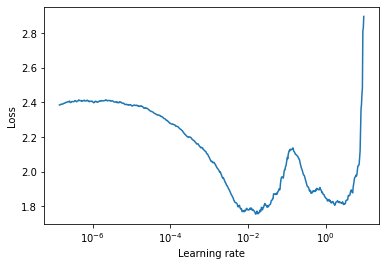

In [0]:
# Training Loss Vs LR
lrfinder.plot()

In [0]:
least_loss_lr = 0
lrfinder_loss_copy = lrfinder.history['loss']
lrfinder_lr_copy   = lrfinder.history['lr']
least_loss_lr = lrfinder_lr_copy[lrfinder_loss_copy.index(min(lrfinder_loss_copy))]
least_loss_lr 

0.015634106081390934

Here **LRFinder Range test** is conducted by evaulating the model on the **test dataset** after each iteration.
The test loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run

---



In [0]:
# To restore the model and optimizer to their initial state
lrfinder.reset()
lrfinder.range_test(trainloader, val_loader=testloader, start_lr=1e-7, end_lr=20, num_iter=500, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Total Observations:  333
Starting Loss:  2.3060082944725457 Ending Loss:  4.655876053136556
Starting Lr:  1.5820664467287618e-07 Ending Lr:  0.05141722536170574
#  1  - Least Loss :  1.9635737980012422 Its corresponding LR:  0.003406923466450139
#  2  - Least Loss :  1.9663507649601892 Its corresponding LR:  0.0032791427087791956
#  3  - Least Loss :  1.9679645147822407 Its corresponding LR:  0.003539683550573464


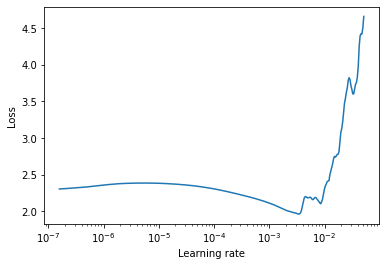

In [0]:
lrfinder.plot()

Finding **starting LR** to start training based on LR Range Test results with val_loader=testloader. This LR will be used inside Optimizer for training.

In [0]:
least_loss_lr = 0
lrfinder_loss_copy = lrfinder.history['loss']
lrfinder_lr_copy   = lrfinder.history['lr']
least_loss_lr = lrfinder_lr_copy[lrfinder_loss_copy.index(min(lrfinder_loss_copy))]
least_loss_lr 

0.003406923466450139

# Train and Test the model using ReduceLROnPlateau

**ReduceLROnPlateau-**Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced by 'factor' supplied. 

mode = 'min' means lr will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing.

'min_lr' -> A lower bound on the LR upto which it can be reduced

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH     = 50

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=testloader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)                  
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))     
       else: 
          print('Test Loss -> Increasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  

    if epoch == (EPOCH -1):
      classwise_acc = calc_classwiseacc(label_total,label_correct)
      class_acc_all.append(classwise_acc)              

  0%|          | 0/391 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 1.3236771821975708 Batch Id = 390 Train Acc = 44.60 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Test Accuracy: 59.86, LR : 0.003407

EPOCH: 1


Train Loss = 0.7204567193984985 Batch Id = 390 Train Acc = 63.06 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Test Accuracy: 67.43, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.008991, Latest Loss: 0.007225, Delta: 0.001766

EPOCH: 2


Train Loss = 0.5772255063056946 Batch Id = 390 Train Acc = 70.50 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Test Accuracy: 72.69, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.007225, Latest Loss: 0.006292, Delta: 0.000933

EPOCH: 3


Train Loss = 0.6820587515830994 Batch Id = 390 Train Acc = 75.27 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Test Accuracy: 76.23, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.006292, Latest Loss: 0.005394, Delta: 0.000898

EPOCH: 4


Train Loss = 0.6183425188064575 Batch Id = 390 Train Acc = 78.00 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Test Accuracy: 77.58, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.005394, Latest Loss: 0.005382, Delta: 0.000013

EPOCH: 5


Train Loss = 0.6182790398597717 Batch Id = 390 Train Acc = 80.52 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Test Accuracy: 79.70, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.005382, Latest Loss: 0.004667, Delta: 0.000714

EPOCH: 6


Train Loss = 0.5483254194259644 Batch Id = 390 Train Acc = 81.79 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Test Accuracy: 80.73, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.004667, Latest Loss: 0.004484, Delta: 0.000183

EPOCH: 7


Train Loss = 0.39649292826652527 Batch Id = 390 Train Acc = 83.18 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Test Accuracy: 81.24, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.004484, Latest Loss: 0.004428, Delta: 0.000057

EPOCH: 8


Train Loss = 0.5116249918937683 Batch Id = 390 Train Acc = 85.10 LR =0.003407: 100%|██████████| 391/391 [00:48<00:00,  7.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Test Accuracy: 79.53, LR : 0.003407
Test Loss -> Increasing, Prev Loss: 0.004428, Latest Loss: 0.005154, Delta: -0.000726

EPOCH: 9


Train Loss = 0.46244722604751587 Batch Id = 390 Train Acc = 85.97 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Test Accuracy: 82.51, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.005154, Latest Loss: 0.004164, Delta: 0.000990

EPOCH: 10


Train Loss = 0.3604864776134491 Batch Id = 390 Train Acc = 86.83 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Test Accuracy: 82.11, LR : 0.003407
Test Loss -> Increasing, Prev Loss: 0.004164, Latest Loss: 0.004663, Delta: -0.000499

EPOCH: 11


Train Loss = 0.33169499039649963 Batch Id = 390 Train Acc = 87.61 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Test Accuracy: 82.39, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.004663, Latest Loss: 0.004243, Delta: 0.000420

EPOCH: 12


Train Loss = 0.31918835639953613 Batch Id = 390 Train Acc = 88.69 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Test Accuracy: 84.39, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.004243, Latest Loss: 0.003737, Delta: 0.000506

EPOCH: 13


Train Loss = 0.30720287561416626 Batch Id = 390 Train Acc = 89.51 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Test Accuracy: 79.45, LR : 0.003407
Test Loss -> Increasing, Prev Loss: 0.003737, Latest Loss: 0.005582, Delta: -0.001845

EPOCH: 14


Train Loss = 0.28530412912368774 Batch Id = 390 Train Acc = 90.18 LR =0.003407: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Test Accuracy: 85.11, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.005582, Latest Loss: 0.003667, Delta: 0.001915

EPOCH: 15


Train Loss = 0.42621809244155884 Batch Id = 390 Train Acc = 91.01 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Test Accuracy: 84.90, LR : 0.003407
Test Loss -> Increasing, Prev Loss: 0.003667, Latest Loss: 0.003950, Delta: -0.000282

EPOCH: 16


Train Loss = 0.14868302643299103 Batch Id = 390 Train Acc = 91.46 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Test Accuracy: 84.95, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.003950, Latest Loss: 0.003736, Delta: 0.000213

EPOCH: 17


Train Loss = 0.2243894338607788 Batch Id = 390 Train Acc = 91.80 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Test Accuracy: 82.86, LR : 0.003407
Test Loss -> Increasing, Prev Loss: 0.003736, Latest Loss: 0.004594, Delta: -0.000857

EPOCH: 18


Train Loss = 0.18246912956237793 Batch Id = 390 Train Acc = 92.28 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Test Accuracy: 84.21, LR : 0.003407
Test Loss -> Decreasing, Prev Loss: 0.004594, Latest Loss: 0.004253, Delta: 0.000340

EPOCH: 19


Train Loss = 0.45922940969467163 Batch Id = 390 Train Acc = 92.70 LR =0.003407: 100%|██████████| 391/391 [00:49<00:00,  7.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 3.4069e-04.

Test set: Average loss: 0.0038, Test Accuracy: 85.68, LR : 0.000341
Test Loss -> Decreasing, Prev Loss: 0.004253, Latest Loss: 0.003788, Delta: 0.000465

EPOCH: 20


Train Loss = 0.07570572197437286 Batch Id = 390 Train Acc = 95.29 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 87.97, LR : 0.000341
Test Loss -> Decreasing, Prev Loss: 0.003788, Latest Loss: 0.003124, Delta: 0.000664

EPOCH: 21


Train Loss = 0.12131873518228531 Batch Id = 390 Train Acc = 96.18 LR =0.000341: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.11, LR : 0.000341
Test Loss -> Decreasing, Prev Loss: 0.003124, Latest Loss: 0.003040, Delta: 0.000084

EPOCH: 22


Train Loss = 0.147304967045784 Batch Id = 390 Train Acc = 96.51 LR =0.000341: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.51, LR : 0.000341
Test Loss -> Increasing, Prev Loss: 0.003040, Latest Loss: 0.003052, Delta: -0.000012

EPOCH: 23


Train Loss = 0.15444746613502502 Batch Id = 390 Train Acc = 96.80 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.59, LR : 0.000341
Test Loss -> Decreasing, Prev Loss: 0.003052, Latest Loss: 0.002998, Delta: 0.000054

EPOCH: 24


Train Loss = 0.049964312463998795 Batch Id = 390 Train Acc = 96.84 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.58, LR : 0.000341
Test Loss -> Increasing, Prev Loss: 0.002998, Latest Loss: 0.003060, Delta: -0.000062

EPOCH: 25


Train Loss = 0.12936390936374664 Batch Id = 390 Train Acc = 96.96 LR =0.000341: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.19, LR : 0.000341
Test Loss -> Increasing, Prev Loss: 0.003060, Latest Loss: 0.003122, Delta: -0.000063

EPOCH: 26


Train Loss = 0.09572280943393707 Batch Id = 390 Train Acc = 97.14 LR =0.000341: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.55, LR : 0.000341
Test Loss -> Decreasing, Prev Loss: 0.003122, Latest Loss: 0.003003, Delta: 0.000119

EPOCH: 27


Train Loss = 0.08915217220783234 Batch Id = 390 Train Acc = 97.22 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.63, LR : 0.000341
Test Loss -> Decreasing, Prev Loss: 0.003003, Latest Loss: 0.002995, Delta: 0.000008

EPOCH: 28


Train Loss = 0.07155518233776093 Batch Id = 390 Train Acc = 97.19 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.59, LR : 0.000341
Test Loss -> Increasing, Prev Loss: 0.002995, Latest Loss: 0.003009, Delta: -0.000013

EPOCH: 29


Train Loss = 0.1872975379228592 Batch Id = 390 Train Acc = 97.30 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.33, LR : 0.000341
Test Loss -> Increasing, Prev Loss: 0.003009, Latest Loss: 0.003058, Delta: -0.000049

EPOCH: 30


Train Loss = 0.10366379469633102 Batch Id = 390 Train Acc = 97.42 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.74, LR : 0.000341
Test Loss -> Increasing, Prev Loss: 0.003058, Latest Loss: 0.003065, Delta: -0.000007

EPOCH: 31


Train Loss = 0.0575607568025589 Batch Id = 390 Train Acc = 97.62 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.72, LR : 0.000341
Test Loss -> Decreasing, Prev Loss: 0.003065, Latest Loss: 0.003063, Delta: 0.000002

EPOCH: 32


Train Loss = 0.11302400380373001 Batch Id = 390 Train Acc = 97.64 LR =0.000341: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    33: reducing learning rate of group 0 to 3.4069e-05.

Test set: Average loss: 0.0031, Test Accuracy: 88.50, LR : 0.000034
Test Loss -> Increasing, Prev Loss: 0.003063, Latest Loss: 0.003077, Delta: -0.000014

EPOCH: 33


Train Loss = 0.080485500395298 Batch Id = 390 Train Acc = 97.68 LR =0.000034: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.72, LR : 0.000034
Test Loss -> Decreasing, Prev Loss: 0.003077, Latest Loss: 0.003048, Delta: 0.000029

EPOCH: 34


Train Loss = 0.0876103863120079 Batch Id = 390 Train Acc = 97.71 LR =0.000034: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.75, LR : 0.000034
Test Loss -> Decreasing, Prev Loss: 0.003048, Latest Loss: 0.003013, Delta: 0.000036

EPOCH: 35


Train Loss = 0.0647599920630455 Batch Id = 390 Train Acc = 97.69 LR =0.000034: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.82, LR : 0.000034
Test Loss -> Increasing, Prev Loss: 0.003013, Latest Loss: 0.003023, Delta: -0.000010

EPOCH: 36


Train Loss = 0.0712704285979271 Batch Id = 390 Train Acc = 97.64 LR =0.000034: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.88, LR : 0.000034
Test Loss -> Increasing, Prev Loss: 0.003023, Latest Loss: 0.003040, Delta: -0.000017

EPOCH: 37


Train Loss = 0.024323854595422745 Batch Id = 390 Train Acc = 97.86 LR =0.000034: 100%|██████████| 391/391 [00:49<00:00,  7.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    38: reducing learning rate of group 0 to 3.4069e-06.

Test set: Average loss: 0.0030, Test Accuracy: 88.80, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003040, Latest Loss: 0.003010, Delta: 0.000030

EPOCH: 38


Train Loss = 0.1236782893538475 Batch Id = 390 Train Acc = 97.87 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.80, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003010, Latest Loss: 0.003002, Delta: 0.000008

EPOCH: 39


Train Loss = 0.07314547896385193 Batch Id = 390 Train Acc = 97.94 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.64, LR : 0.000003
Test Loss -> Increasing, Prev Loss: 0.003002, Latest Loss: 0.003082, Delta: -0.000080

EPOCH: 40


Train Loss = 0.08309110999107361 Batch Id = 390 Train Acc = 97.76 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.79, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003082, Latest Loss: 0.003030, Delta: 0.000053

EPOCH: 41


Train Loss = 0.062148865312337875 Batch Id = 390 Train Acc = 97.96 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.76, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003030, Latest Loss: 0.003022, Delta: 0.000008

EPOCH: 42


Train Loss = 0.06959182024002075 Batch Id = 390 Train Acc = 97.77 LR =0.000003: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.70, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003022, Latest Loss: 0.002983, Delta: 0.000039

EPOCH: 43


Train Loss = 0.057857077568769455 Batch Id = 390 Train Acc = 97.83 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Test Accuracy: 88.78, LR : 0.000003
Test Loss -> Increasing, Prev Loss: 0.002983, Latest Loss: 0.003069, Delta: -0.000086

EPOCH: 44


Train Loss = 0.06787453591823578 Batch Id = 390 Train Acc = 97.84 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.72, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003069, Latest Loss: 0.003020, Delta: 0.000049

EPOCH: 45


Train Loss = 0.028189025819301605 Batch Id = 390 Train Acc = 97.79 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.79, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003020, Latest Loss: 0.002991, Delta: 0.000029

EPOCH: 46


Train Loss = 0.0400809720158577 Batch Id = 390 Train Acc = 97.89 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.87, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.002991, Latest Loss: 0.002980, Delta: 0.000011

EPOCH: 47


Train Loss = 0.06565017253160477 Batch Id = 390 Train Acc = 97.76 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.89, LR : 0.000003
Test Loss -> Increasing, Prev Loss: 0.002980, Latest Loss: 0.003009, Delta: -0.000030

EPOCH: 48


Train Loss = 0.16864970326423645 Batch Id = 390 Train Acc = 97.92 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Test Accuracy: 88.80, LR : 0.000003
Test Loss -> Increasing, Prev Loss: 0.003009, Latest Loss: 0.003030, Delta: -0.000020

EPOCH: 49


Train Loss = 0.1066746637225151 Batch Id = 390 Train Acc = 97.81 LR =0.000003: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]



Test set: Average loss: 0.0030, Test Accuracy: 88.72, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.003030, Latest Loss: 0.003008, Delta: 0.000022
Test accuracy for class -  0  -  plane  :  92.0 correct: 920 Total: 1000
Test accuracy for class -  1  -  automob  :  95.9 correct: 959 Total: 1000
Test accuracy for class -  2  -  bird  :  85.2 correct: 852 Total: 1000
Test accuracy for class -  3  -  cat  :  74.5 correct: 745 Total: 1000
Test accuracy for class -  4  -  deer  :  85.4 correct: 854 Total: 1000
Test accuracy for class -  5  -  dog  :  82.5 correct: 825 Total: 1000
Test accuracy for class -  6  -  frog  :  92.3 correct: 923 Total: 1000
Test accuracy for class -  7  -  horse  :  92.8 correct: 928 Total: 1000
Test accuracy for class -  8  -  ship  :  93.8 correct: 938 Total: 1000
Test accuracy for class -  9  -  truck  :  92.8 correct: 928 Total: 1000
Total Test Images: 10000 Correct Images: 8872


#### Below section of code is to plot **misclassified images** received from last epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


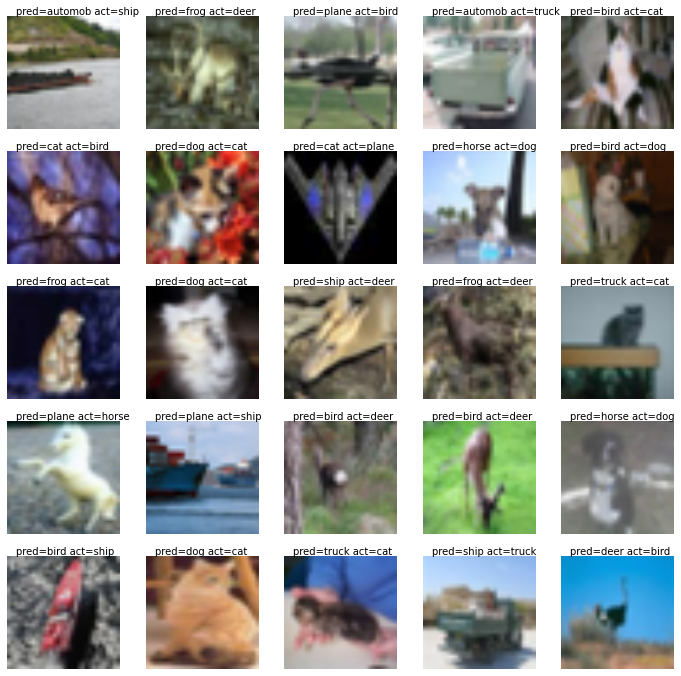

In [0]:
# Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. 
# In case of such an event adjust the subplots to suit the number of images to be plotted

figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      #plt.imshow(unnormalize(wrong_predict[i].cpu()), interpolation='none')
      plt.imshow(unnormalize(wrong_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(predicted_class[i])
      actual     = class_names_dict.get(actual_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      #s="predicted="+str(predicted_class[i])+" actual="+str(actual_class[i])
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Below section of code is to plot **validation accuracy, test loss, training accuracy and train loss** for the all the epochs trained

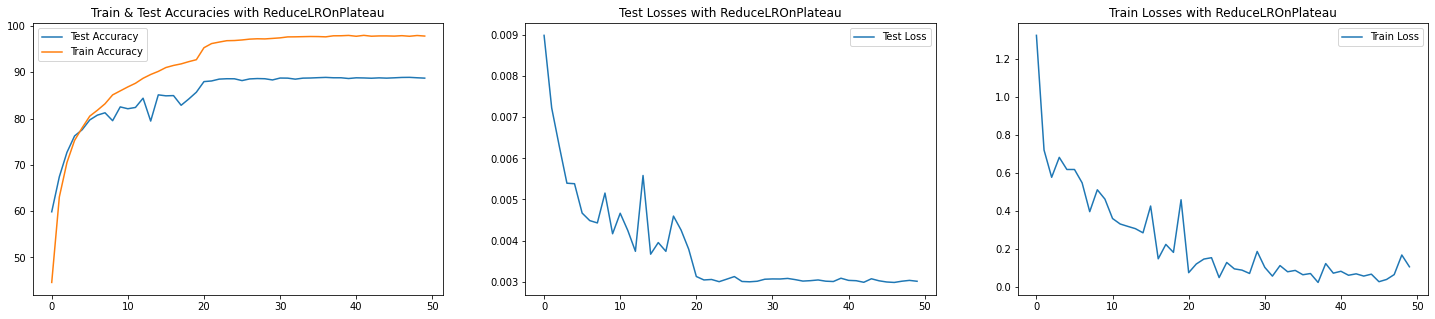

In [0]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")   

##Gradcam



In [0]:
img_all = img_1 = img_2 = img_3 = []
target_all = target_1 = target_2 = target_3 = []
test1_transforms   = Alb_data_transforms.Albumentations_transform([])
target_layers = ["layer1","layer2","layer3","layer4"]
#Grad_CAM1(model,target_layers)

for i in range(len(wrong_predict)):
     img = wrong_predict[i].cpu().numpy()
     img = np.transpose(img, (1,2,0))
     img = test1_transforms(img)
     img_all.append(img)
     target_all.append(actual_class[i])

img_1 = img_all[0:10]
img_2 = img_all[10:20]
img_3 = img_all[20:25]
target_1 = target_all[0:10]
target_2 = target_all[10:20]
target_3 = target_all[20:25]

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


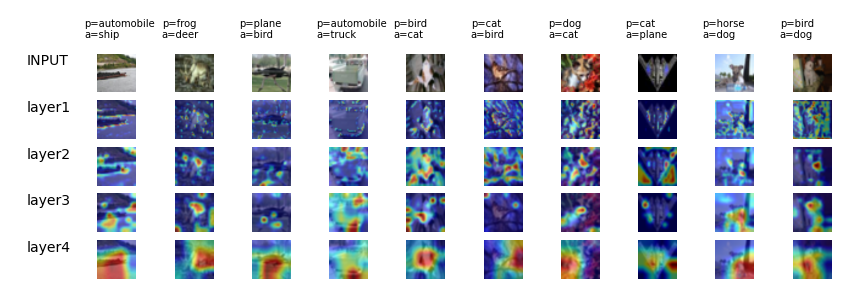

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


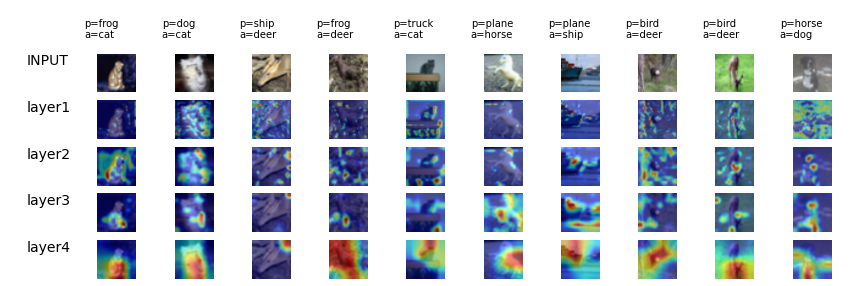

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


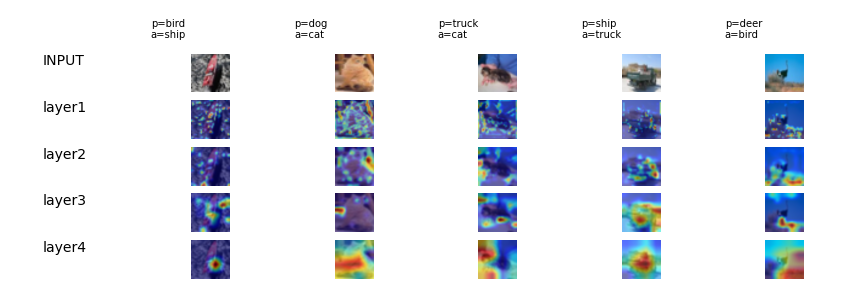

In [0]:
images = []
target_classes = [] 
grad_cam_list = [1,2,3]
for i in range(len(grad_cam_list)):
    if i == 0:
      images = img_1
      target_classes = target_1
    elif i == 1:
      images = img_2
      target_classes = target_2
    elif i == 2:
      images = img_3
      target_classes = target_3    
    gradcam_output, probs, predicted_classes = Gradcam.GRADCAM(images, target_classes, model, target_layers)
    Gradcam.PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
    images = []
    target_classes = []     

### Next few cells are for testing only. Will be **deleted later**
### Train Loss, Test Loss & Module run to test **ReduceLROnPlateau**

In [0]:
'''
########### Train Loss

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# # class for Calculating and storing training losses and training accuracies of model for each batch per epoch ## 
class Train_loss:
        
      def train_loss_calc(self,model, device, train_loader, optimizer, epoch, factor, criterion, scheduler =None, print_idx=0, maxlr=0):
            
          self.model        = model
          self.device       = device
          self.train_loader = train_loader
          self.optimizer    = optimizer   
          self.epoch        = epoch
          self.factor       = factor
          self.criterion    = criterion      
          self.scheduler    = scheduler
          self.print_idx    = print_idx
          self.maxlr        = maxlr    
          #self.metric       = 0      
          
          model.train()
          pbar = tqdm(train_loader)  # Wrapping train_loader in tqdm to show progress bar for each epoch while training          
            
          correct             = 0
          total               = 0
          train_losses        = []
          train_acc           = []
          
          for batch_idx, data in enumerate(pbar,0):
                        
              images, labels = data        
                       
              images, labels = images.to(device), labels.to(device)   # Moving images and correspondig labels to GPU
              optimizer.zero_grad()  # Zeroing out gradients at start of each batch so that backpropagation won't take accumulated value
              labels_pred = model(images)  # Calling CNN model to predict the images
              loss = criterion(labels_pred, labels)   # Calculating Negative Likelihood Loss by comparing prediction vs ground truth
              
              # Applying L1 regularization to the training loss calculated
              L1_criterion = nn.L1Loss(size_average = None, reduce = None, reduction = 'mean')
              reg_loss     = 0
              for param in model.parameters():
                zero_tensor = torch.rand_like(param) * 0 # Creating a zero tensor with same size as param
                reg_loss    += L1_criterion(param, zero_tensor)
              loss += factor * reg_loss 
              
            
              # Backpropagation
              loss.backward()
              optimizer.step()
              
              # This was used for OneCycle LR policy. 'get_last_lr()' giving error while using ReduceLRonPlateau hence commenting out 
              #lr = self.scheduler.get_last_lr()[0] if self.scheduler else (self.optimizer.lr_scheduler.get_last_lr()[0] if self.optimizer.lr_scheduler else self.optimizer.param_groups[0]['lr'])
              
              lr = 0
              #print('self.scheduler:', self.scheduler,'scheduler:', scheduler)
              #print(isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau))                 
              #print('batch_idx:', batch_idx)
              #print('self.optimizer:',self.optimizer,'optimizer:',optimizer)
              #print('self.optimizer.lr_policy:', self.optimizer.lr_policy)   
              #print('self.optimizer.param_groups[0][lr]:', self.optimizer.param_groups[0]['lr'])
        
              #if scheduler:   # this is for batchwise lr update
              #   print('Entering steps:',scheduler)   
              #   scheduler.step(self.metric) 
              #print('lr - scheduler.get_last_lr()[0]:', scheduler.get_last_lr()[0])        
        
              if scheduler and not (isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)):
                 lr = self.scheduler.get_last_lr()[0]
              else:
                 lr = self.optimizer.param_groups[0]['lr']                
                
              #if self.scheduler:   # this is for batchwise lr update
              #   self.scheduler.step(batch_idx)    
                        
              # Calculating accuracies
              labels_pred_max = labels_pred.argmax(dim = 1, keepdim = True) # Getting the index of max log probablity predicted by model
              correct         += labels_pred_max.eq(labels.view_as(labels_pred_max)).sum().item() # Getting count of correctly predicted
              total           += len(images) # Getting count of processed images
              train_acc_batch = (correct/total)*100            
              pbar.set_description(desc=f'Train Loss = {loss.item} Batch Id = {batch_idx} Train Accuracy = {train_acc_batch:0.2f} LR = {lr}')                                   
                                        
              #if self.scheduler:   # this is for batchwise lr update
              #   self.scheduler.step(lr) 
              #   print('final lr:',lr)

          train_acc.append(train_acc_batch)  # To capture only final batch accuracy of an epoch
          train_losses.append(loss)          # To capture only final batch loss of an epoch
        
          return train_losses, train_acc    
'''               

In [0]:
'''
#############TEST LOSS

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # class for Calculating and storing testing losses and testing accuracies of model for each epoch ## 
class Test_loss:

       def test_loss_calc(self,model, device, test_loader, optimizer, total_epoch, current_epoch, criterion, scheduler):
           self.model        = model
           self.device       = device
           self.test_loader  = test_loader
           self.optimizer    = optimizer
           self.total_epoch  = total_epoch
           self.current_epoch= current_epoch
           self.criterion    = criterion
           self.scheduler    = scheduler
       
           model.eval()
           
           correct        = 0 
           total          = 0              
           test_loss      = 0
           test_accuracy  = 0 
           test_losses    = []
           test_acc       = []
           predicted_class= []
           actual_class   = []
           wrong_predict  = []
           count_wrong    = 0 
           
           label_dict     = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
           label_total    = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
           label_correct  = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}   
                       
           with torch.no_grad():                     # For test data, we won't do backprop, hence no need to capture gradients
                for images,labels in test_loader:    # We are working in GPU, so 1 iteration will process 128 images(batch_size) in a go. Total 10,000/128 = 79 iterations will happen
 
                    images,labels    = images.to(device),labels.to(device)                                      # Images -> Tensor with shape torch.Size([128, 3, 32, 32])
                    labels_pred      = model(images)                                                            # labels_pred -> Tensor with shape torch.Size([128, 10]) 
                    #test_loss       += criterion(labels_pred, labels, reduction = 'sum').item()                # Use torch.Tensor.item() to get a Python number from a tensor containing a single value              
                    test_loss        += criterion(labels_pred, labels).item()                                   # Use torch.Tensor.item() to get a Python number from a tensor containing a single value                
                    labels_pred_max  = labels_pred.argmax(dim =1, keepdim = True)                               # labels_pred_max -> Tensor with shape torch.Size([128, 1]). We are taking maximum value out of 10 from 'labels_pred' tensor
                    correct          += labels_pred_max.eq(labels.view_as(labels_pred_max)).sum().item()        # labels -> Tensor with shape torch.Size([128]). We are changing shape of labels to ([128, 1]) for comparison purpose
                    total            += labels.size(0)                                                          # Taking number of labels in each batch size and accumulating it to get total images at end. Here labels.size(0)  = 128
                    ''' 
                    ''' labels_pred_max will look like below: torch.Size([128, 1])
                     ([[3],
                       [0],
                       [5],
                       .
                       .
                       [7]], device='cuda:0') -> 128th element
                       
                       labels will look like below: torch.Size([128])
                       ([3, 2, 5, 5, 0, 9,.....4, 4], device='cuda:0') 
                       
                       labels_pred will look like below: torch.Size([128, 10])
                       tensor([[-1.3098e+00, -5.1958e+00, -4.3112e+00,  ..., -6.5936e+00,
                                -4.1666e-01, -4.0672e+00], -> 10 elements in each row
                               [-7.6204e+00, -9.2902e+00, -4.8976e+00,  ..., -1.4079e-01,
                                -9.6599e+00, -8.5457e+00],
                                .
                                .
                               [-2.2386e+00, -3.1282e+00, -4.0142e+00,  ..., -2.4335e+00,
                                -4.5057e+00, -1.2379e+00]], device='cuda:0') -> 128th row
                      
                      * labels_pred_max.item() -> This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value   
                      * labels.item() ->  This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value
                      * labels_pred.item() ->  This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value
                      * labels.view_as(labels_pred_max).item() -> This will fail because torch.Tensor.item() is to get a Python number from a tensor containing a single value
                      * if labels_pred_max == labels:  -> This will fail beacuse we are comparing different shapes                                        
                      * len(labels_pred_max) = 128 which is same as batch_size
                      * if labels_pred_max[i] == labels[i]: -> This will work because we are gathering specific elements and comparing
                      * if labels_pred_max[2] == labels[2]: -> This will work because we are gathering specific elements and comparing
                      * labels_pred_max[i] -> Will look like tensor([5], device='cuda:0') 
                      * labels[i] -> Will look like tensor(2, device='cuda:0')
                      * labels[i].item() -> Will work & return an integer
                      * labels_pred_max[i].item() -> Will work & return an integer
                    '''
                    '''
                    if current_epoch == (total_epoch - 1): 
                           for i in range(len(labels_pred_max)):
                               counter_key = ' '
                               counter_key = label_dict.get(labels[i].item())   # Getting labels from 'label_dict'
                               label_total[counter_key] += 1                    # Increasing total count of corresponding label

                               if labels_pred_max[i] == labels[i]:
                                  label_correct[counter_key] += 1               # Increasing correct count of corresponding label
                               else:    
                                  if count_wrong   < 26:                                            # Capturing 26 wrongly predicted images for last epoch
                                     wrong_predict.append(images[i])                                # with its predicted and actual class 
                                     predicted_class.append(labels_pred_max[i].item())
                                     actual_class.append(labels[i].item())
                                     count_wrong += 1
              
                test_loss   /= total  # Calculating overall test loss for the epoch
                test_losses.append(test_loss)    
                                  
                test_accuracy =  (correct/total)* 100
                test_acc.append(test_accuracy)                       
            
                lr = 0              
                if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                   lr = self.scheduler.get_last_lr()[0]
                else:
                   lr = self.optimizer.param_groups[0]['lr']
                #print('lr before scheduler.step():',lr)                                
                
                scheduler.step(test_loss)
                lr = self.optimizer.param_groups[0]['lr']
                #print('lr after scheduler.step():',lr)    
               
                print('\nTest set: Average loss: {:.4f}, Test Accuracy: {:.2f}, Learning Rate: {:.6f}\n' .format(test_loss, test_accuracy,lr))

           return test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct

In [0]:
'''
train_loss = Train_loss()
test_loss  = Test_loss()
least_loss_lr = 0.008
'''

In [0]:
'''
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH     = 3

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=testloader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)

    if epoch == (EPOCH -1):
      classwise_acc = calc_classwiseacc(label_total,label_correct)
      class_acc_all.append(classwise_acc)                          
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing')     
       else: 
          print('Test Loss -> Increasing') 
       print('Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  
'''           

#### **Gradcam code** to accept & display external images

In [0]:
'''
Below code section shows how to receive & prepare external images for Gradcam

# This will upload the zip file to colab. A prompt will appear to choose files
from google.colab import files
uploaded = files.upload()
# To import zipfile
import zipfile
from zipfile import ZipFile 
file_name = "S9_GradCam_Images.zip"
with ZipFile(file_name, 'r') as zip: 
     zip.printdir()
     zip.extractall() 
# To list the files in directory
import os
for img in os.listdir('S9_GradCam_Images/'):  
    img_name = os.path.join('S9_GradCam_Images/',img)  # convert to array
    print(img_name)     
# Preparing image for GradCAM
gradcam_images = [(0, 'S9_GradCam_Images/Plane_2.jpg'),
                  (1, 'S9_GradCam_Images/Car_2.jpg'),
                  (2, 'S9_GradCam_Images/Bird_2.jpg'),
                  (3, 'S9_GradCam_Images/Cat_2.jpg'),
                  (4, 'S9_GradCam_Images/Deer_1.jpg'),
                  (5, 'S9_GradCam_Images/Dog_2.jpg'),
                  (6, 'S9_GradCam_Images/Frog_1.jpg'),
                  (7, 'S9_GradCam_Images/Horse_2.jpg'),
                  (8, 'S9_GradCam_Images/Ship_2.jpg'),
                  (9, 'S9_GradCam_Images/Truck_1.jpg')]

images = []
target_classes = []

j = 0
for i in gradcam_images:
  if j == 0:
    images.append(getimage(i[1], test_transforms))
    target_classes.append(i[0])  

def getimage(img, transform,input_size=(32,32)):
    img = cv2.imread(img, 1)
    img = img[:,:, -1::-1]
    img = np.uint8(cv2.resize(img, input_size))
    img = transform(img)
    img = np.transpose(img, (0,1,2))
    return img
'''      

In [0]:
'''
class Grad_CAM1:
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers 
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output):
              #print('forward_hook1')
              self.fmap_pool[key] = output.detach()

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out):
              #print('backward_hook1')
              self.grad_pool[key] = grad_out[0].detach()

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

def GRAD_CAM1(images, labels, model, target_layers):
  model.eval()
  # map input to device
  images = torch.stack(images).to(model.device)
  # set up grad cam
  gcam = Grad_CAM1(model, target_layers)
  # forward pass
  probs, ids = gcam.forward(images)
  # outputs agaist which to compute gradients
  ids_ = torch.LongTensor(labels).view(len(images),-1).to(model.device)
  # backward pass
  gcam.backward(ids=ids_)
  layers = []
  for i in range(len(target_layers)):
    target_layer = target_layers[i]
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    layers.append(gcam.generate(target_layer=target_layer))
  # remove hooks when done
  gcam.remove_hook()
  return layers, probs, ids

def Gradcam_PLOT(gcam_layers, images, labels, target_layers, class_names, image_size, predicted, unnormalize):
    c = len(images)+1
    #print('c:',c)
    r = len(target_layers)+2
    #print('r:',r)
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=14)
    plt.axis('off')
    #print('len(target_layers):',len(target_layers))
    for i in range(len(target_layers)):
      #print('i:',i)
      target_layer = target_layers[i]
      #print('target_layers[i]:',target_layers[i])
      ax = plt.subplot(r, c, c*(i+1)+1)
      #print('r, c, c*(i+1)+1:',r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=14)
      plt.axis('off')

      for j in range(len(images)):
        #print('j:',j)
        img = np.uint8(255*unnormalize(images[j].view(image_size)))
        #img = np.uint8(unnormalize(images[j].view(image_size)))
        if i==0:
          ax = plt.subplot(r, c, j+2)
          #print('r,c,j+2:',r,c,j+2)
          ax.text(0, 0.2, f"p={class_names[predicted[j][0]]}\na={class_names[labels[j]]}", fontsize=10)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          #print('r,c,c+j+2:',r,c,c+j+2)
          plt.imshow(img, interpolation='bilinear')
          plt.axis('off')
          
        
        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        #heatmap = np.uint8(heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        #print('r, c, (i+2)*c+j+2:',r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')
        
        plt.axis('off')
    plt.show()
'''    

'\nclass Grad_CAM1:\n    """ Class for extracting activations and \n    registering gradients from targetted intermediate layers \n    target_layers = list of convolution layer index as shown in summary\n    """\n    def __init__(self, model, candidate_layers=None):\n        def save_fmaps(key):\n          def forward_hook(module, input, output):\n              #print(\'forward_hook1\')\n              self.fmap_pool[key] = output.detach()\n\n          return forward_hook\n\n        def save_grads(key):\n          def backward_hook(module, grad_in, grad_out):\n              #print(\'backward_hook1\')\n              self.grad_pool[key] = grad_out[0].detach()\n\n          return backward_hook\n\n        self.device = next(model.parameters()).device\n        self.model = model\n        self.handlers = []  # a set of hook function handlers\n        self.fmap_pool = {}\n        self.grad_pool = {}\n        self.candidate_layers = candidate_layers  # list\n\n        for name, module in self.m